history match the freyberg model using a single ``K`` parameter and a single recharge parameter

In [9]:
%matplotlib inline
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyemu
import platform
if 'window' in platform.platform().lower():
    newln='\n'
    ppp = 'pest++ '
    pref = ''
else:
    newln='\r\n'
    ppp = './pestpp '
    pref = './'

In [2]:
base_dir = os.path.join("..","..","models","Freyberg","Freyberg_K_and_R")
assert os.path.exists(base_dir)
[shutil.copy2(os.path.join(base_dir,f),f) for f in os.listdir(base_dir)];

Let's do some monte carlo

In [3]:
pst = pyemu.Pst("freyberg.pst")
pst.parameter_data.loc["rch1","partrans"] = "log" #make recharge adjustable
#pst.parameter_data.loc["hk1","parubnd"] = 100.0
#pst.parameter_data.loc["hk1","parlbnd"] = 10.0
#pst.parameter_data.loc["rch1","partrans"] = "none"
#pst.parameter_data.loc["rch1","parlbnd"] = pst.parameter_data.loc["rch1","parval1"] * 0.75
#pst.parameter_data.loc["rch1","parubnd"] = pst.parameter_data.loc["rch1","parval1"] * 1.25 
pst.parameter_data


,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
parnme,,,,,,,,,,
rch1,rch1,log,factor,0.000110,0.000079,0.000155,rch,1.0,0.0,1
rch2,rch2,fixed,factor,0.000094,0.000079,0.000155,rch,1.0,0.0,1
hk1,hk1,log,factor,8.000000,1.250000,80.000000,hk,1.0,0.0,1


In [4]:
mc = pyemu.MonteCarlo(pst=pst)
mc

In [5]:
mc.draw(num_reals=1000,enforce_bounds=True,)

In [6]:
mc.parensemble.head()

parnme,rch1,rch2,hk1
0,9.85944e-05,0.000094,5.04638
1,0.000104094,0.000094,10.5739
2,9.26522e-05,0.000094,23.2559
3,0.000106161,0.000094,16.8838
4,0.0001076,0.000094,2.72508


7.9e-05 0.000155 0.000111275202977


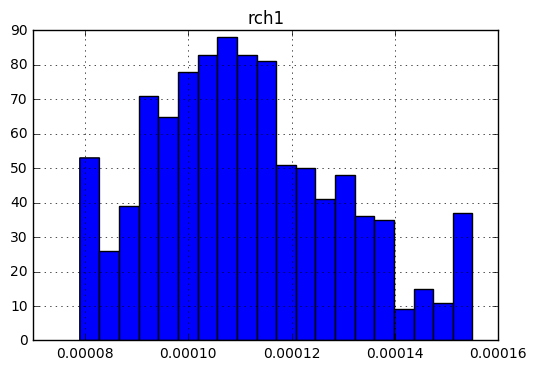

9.358508e-05 9.358508e-05 9.358507999999989e-05


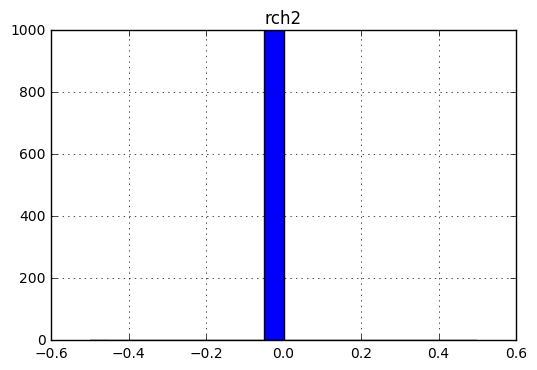

1.25 80.0 12.9520290701


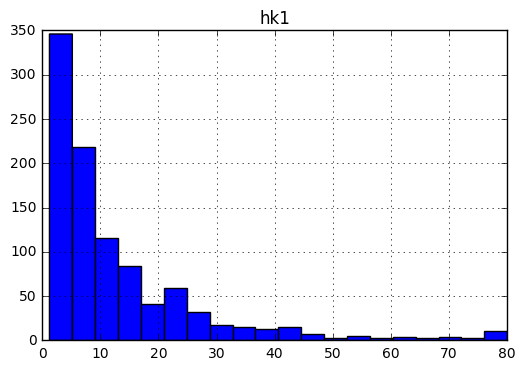

In [7]:
for pname in mc.pst.par_names:
    ax = mc.parensemble.loc[:,pname].hist(bins=20)
    print(mc.parensemble.loc[:,pname].min(),mc.parensemble.loc[:,pname].max(),mc.parensemble.loc[:,pname].mean())
    ax.set_title(pname)
    plt.show()
    

In [8]:
pst.parameter_data

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
parnme,,,,,,,,,,
rch1,rch1,log,factor,0.000110,0.000079,0.000155,rch,1.0,0.0,1
rch2,rch2,fixed,factor,0.000094,0.000079,0.000155,rch,1.0,0.0,1
hk1,hk1,log,factor,8.000000,1.250000,80.000000,hk,1.0,0.0,1


In [21]:
mc.parensemble.to_csv("sweep_in.csv")

In [22]:
pyemu.helpers.start_slaves(base_dir,"{0}sweep".format(pref),"freyberg.pst",num_slaves=20,master_dir='.')

In [23]:
df_out = pd.read_csv("sweep_out.csv",index_col=0)
df_out = df_out.loc[df_out.failed_flag==0,:] #drop an failed runs
df_out.head()

,failed_flag,phi,meas_phi,regul_phi,TRAVEL_FORE,HEAD_FORE,FLUX_FORE,HEAD_CAL,FLUX_CAL,CR03C16,...,FR27C7,FR30C16,FR34C8,FR35C11,FR02C02,FR01C13,FR09C15,FR25C10,RIVFLUX_FORE,TRAVEL_TIME
run_id,,,,,,,,,,,,,,,,,,,,,
0,0,34.188207,34.188207,0.0,0.0,0.0,0.0,34.188207,0.0,19.65175,...,19.62833,14.28030,16.64464,13.92781,28.45563,20.77822,17.24020,17.55951,-2092.202,24967.56
1,0,106.640374,106.640374,0.0,0.0,0.0,0.0,106.640374,0.0,19.50885,...,17.75149,13.91821,15.67561,13.68943,25.18848,20.34859,17.71954,16.42496,-2186.128,16152.86
2,0,156.934915,156.934915,0.0,0.0,0.0,0.0,156.934915,0.0,19.42596,...,17.02099,13.81508,15.29754,13.56338,23.91133,20.19725,17.81384,15.99474,-1978.839,14032.62
3,0,276.047085,276.047085,0.0,0.0,0.0,0.0,276.047085,0.0,19.34539,...,15.69810,13.59145,14.69699,13.46056,21.29308,19.91594,18.11782,15.26266,-2450.686,7044.73
4,0,236.931201,236.931201,0.0,0.0,0.0,0.0,236.931201,0.0,19.35753,...,16.10460,13.66704,14.86830,13.47079,22.15153,20.00648,18.00623,15.48045,-2037.760,9664.04


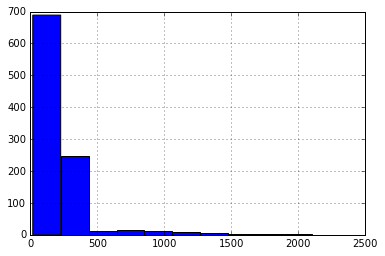

In [24]:
df_out.phi.hist()

## PAY ATTENTION:  this is super important - we are choosing which realizations we consider ``good enough`` with respect to fitting the observation data

In [37]:
acceptable_phi = 35.0
good_enough = df_out.loc[df_out.phi<acceptable_phi].index.values
print(good_enough)

[  0   9  13  15  20  30  36  42  58  61  65  75  84  85 101 103 106 119
 124 154 155 186 188 189 196 205 211 212 215 236 248 257 262 268 274 284
 285 291 292 294 295 296 301 303 314 322 331 333 354 356 359 361 363 373
 374 380 392 398 403 408 410 415 418 423 430 436 447 453 458 463 465 466
 469 492 496 515 518 519 524 533 546 549 564 566 582 588 602 606 608 611
 616 625 632 639 657 661 676 685 688 690 692 695 702 711 720 721 736 742
 745 750 753 754 774 790 795 801 804 834 839 844 853 858 862 869 881 883
 885 902 907 910 915 917 921 932 950 952 956 965 982 998]


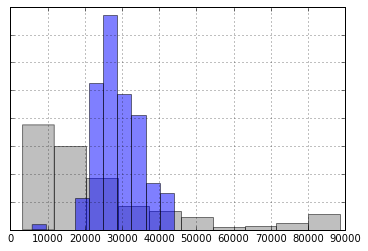

In [38]:
ax = df_out.TRAVEL_TIME.hist(alpha=0.5,color='0.5',normed=True)
ax.set_yticklabels([])
df_out.loc[good_enough,"TRAVEL_TIME"].hist(ax=ax,alpha=0.5,color='b',normed=True)

[]

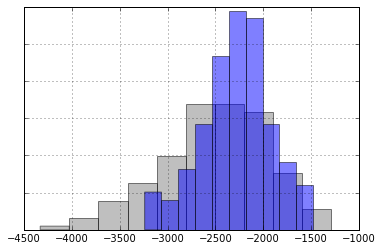

In [39]:
ax = df_out.RIVFLUX_FORE.hist(alpha=0.5,color="0.5",normed=True)
df_out.loc[good_enough,"RIVFLUX_FORE"].hist(ax=ax,color='b',alpha=0.5,normed=True)
ax.set_yticklabels([])

[]

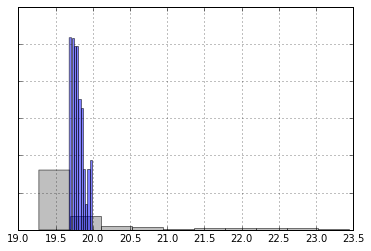

In [40]:
ax = df_out.FR03C16.hist(alpha=0.5,color="0.5",normed=True)
df_out.loc[good_enough,"FR03C16"].hist(ax=ax,color='b',alpha=0.5,normed=True)
ax.set_yticklabels([])